label
no-hate    3098
hate       3029
label         1
Name: count, dtype: int64
Binary Label Mapping:
Original Label: hate -> Encoded Label: 0
Original Label: no-hate -> Encoded Label: 1

Multi-Class Label Mapping:
Original Label: bullying -> Encoded Label: 0
Original Label: insult -> Encoded Label: 1
Original Label: misogyny -> Encoded Label: 2
Original Label: none -> Encoded Label: 3
Original Label: political_hate -> Encoded Label: 4
Original Label: racism -> Encoded Label: 5
Original Label: religious_hate -> Encoded Label: 6
Original Label: violence_incitement -> Encoded Label: 7


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/825k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Layer 0: Requires Grad = False
Layer 1: Requires Grad = False
Layer 2: Requires Grad = False
Layer 3: Requires Grad = False
Layer 4: Requires Grad = False
Layer 5: Requires Grad = False
Layer 6: Requires Grad = False
Layer 7: Requires Grad = False
Layer 8: Requires Grad = True
Layer 9: Requires Grad = True
Layer 10: Requires Grad = True
Layer 11: Requires Grad = True


Epoch,Training Loss,Validation Loss,Binary Accuracy,Binary F1,Binary Precision,Binary Recall,Multi Class Accuracy,Multi Class F1,Multi Class Precision,Multi Class Recall
1,1.344400,1.057200,0.903156,0.902942,0.907906,0.903156,0.754081,0.763345,0.794859,0.754081
2,0.817200,0.817829,0.916213,0.915992,0.921927,0.916213,0.806311,0.812949,0.832817,0.806311
3,0.643000,0.686867,0.935800,0.935767,0.937353,0.935800,0.834603,0.840614,0.856193,0.834603
4,0.536600,0.635794,0.937976,0.937944,0.939535,0.937976,0.856366,0.859916,0.870600,0.856366
5,0.329800,0.629644,0.931447,0.931448,0.931451,0.931447,0.872688,0.874485,0.878530,0.872688
6,0.289100,0.642242,0.937976,0.937961,0.938926,0.937976,0.868335,0.871089,0.877935,0.868335
7,0.217500,0.622265,0.941240,0.941242,0.941280,0.941240,0.886834,0.889106,0.893836,0.886834
8,0.269900,0.642826,0.942329,0.942330,0.942512,0.942329,0.883569,0.886188,0.891400,0.883569
9,0.145000,0.639326,0.935800,0.935795,0.936289,0.935800,0.879217,0.882283,0.888512,0.879217
10,0.177800,0.647165,0.937976,0.937972,0.938467,0.937976,0.882481,0.885830,0.892749,0.882481



Test Set Results:
Binary Classification Metrics:
  Accuracy: 0.9435
  Precision: 0.9440
  Recall: 0.9435
  F1-Score: 0.9435

Multi-Class Classification Metrics:
  Accuracy: 0.8663
  Precision: 0.8672
  Recall: 0.8663
  F1-Score: 0.8660


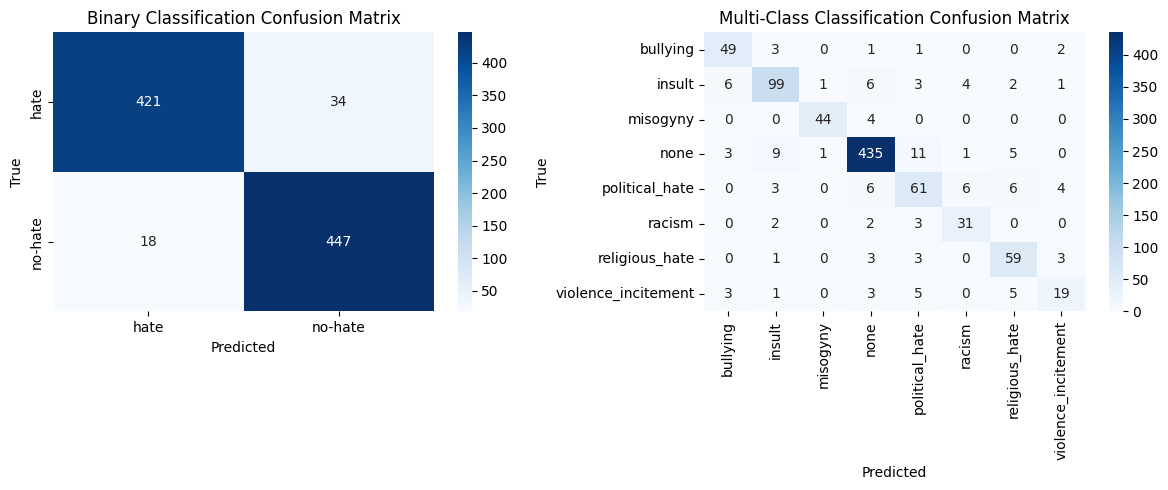

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from transformers import BertTokenizer, BertModel, Trainer, TrainingArguments
import torch
import re
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import EarlyStoppingCallback


df = pd.read_csv('/content/data.csv', header=None, names=['id', 'text', 'platform', 'label', 'type'])
print(df['label'].value_counts())


def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def normalize_arabic(text):
    text = re.sub(r"[\u0621\u0623\u0625]", "\u0627", text)  # Replace أ, إ, آ with ا
    text = re.sub(r"[\u0640]", "", text)
    text = re.sub(r"[\u0649]", "\u064A", text)  # Replace ى with ي
    return text

def preprocess_text(text):
    text = clean_text(text)
    text = normalize_arabic(text)
    return text


df['text'] = df['text'].apply(preprocess_text)
df = df[df['label'] != 'label']
df = df[df['type'] != 'type']


binary_encoder = LabelEncoder()
multi_class_encoder = LabelEncoder()
df['is_hate_speech'] = binary_encoder.fit_transform(df['label'])
df['type_encoded'] = multi_class_encoder.fit_transform(df['type'])


print("Binary Label Mapping:")
for original_label, encoded_label in zip(binary_encoder.classes_, range(len(binary_encoder.classes_))):
    print(f"Original Label: {original_label} -> Encoded Label: {encoded_label}")
print("\nMulti-Class Label Mapping:")
for original_label, encoded_label in zip(multi_class_encoder.classes_, range(len(multi_class_encoder.classes_))):
    print(f"Original Label: {original_label} -> Encoded Label: {encoded_label}")


train_texts, temp_texts, train_binary_labels, temp_binary_labels, train_multi_class_labels, temp_multi_class_labels = train_test_split(
    df['text'], df['is_hate_speech'], df['type_encoded'],
    test_size=0.3, random_state=42, stratify=df['type_encoded']
)
val_texts, test_texts, val_binary_labels, test_binary_labels, val_multi_class_labels, test_multi_class_labels = train_test_split(
    temp_texts, temp_binary_labels, temp_multi_class_labels,
    test_size=0.5, random_state=42, stratify=temp_binary_labels
)


train_df = pd.DataFrame({
    'text': train_texts,
    'is_hate_speech': train_binary_labels,
    'type_encoded': train_multi_class_labels
})
val_df = pd.DataFrame({
    'text': val_texts,
    'is_hate_speech': val_binary_labels,
    'type_encoded': val_multi_class_labels
})
test_df = pd.DataFrame({
    'text': test_texts,
    'is_hate_speech': test_binary_labels,
    'type_encoded': test_multi_class_labels
})

binary_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['is_hate_speech']),
    y=train_df['is_hate_speech']
)
multi_class_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['type_encoded']),
    y=train_df['type_encoded']
)


binary_class_weights = torch.tensor(binary_class_weights, dtype=torch.float).to('cuda' if torch.cuda.is_available() else 'cpu')
multi_class_class_weights = torch.tensor(multi_class_class_weights, dtype=torch.float).to('cuda' if torch.cuda.is_available() else 'cpu')


tokenizer = BertTokenizer.from_pretrained('aubmindlab/bert-base-arabertv02')
def tokenize_function(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=128)

train_encodings = tokenize_function(train_df['text'].tolist())
val_encodings = tokenize_function(val_df['text'].tolist())
test_encodings = tokenize_function(test_df['text'].tolist())

class HateSpeechDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, binary_labels, multi_class_labels):
        self.encodings = encodings
        self.binary_labels = binary_labels
        self.multi_class_labels = multi_class_labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['binary_labels'] = torch.tensor(self.binary_labels[idx])
        item['multi_class_labels'] = torch.tensor(self.multi_class_labels[idx])
        return item

    def __len__(self):
        return len(self.binary_labels)

train_dataset = HateSpeechDataset(train_encodings, train_df['is_hate_speech'].tolist(), train_df['type_encoded'].tolist())
val_dataset = HateSpeechDataset(val_encodings, val_df['is_hate_speech'].tolist(), val_df['type_encoded'].tolist())
test_dataset = HateSpeechDataset(test_encodings, test_df['is_hate_speech'].tolist(), test_df['type_encoded'].tolist())


class MultiTaskBertForSequenceClassification(torch.nn.Module):
    def __init__(self, base_model_name, num_binary_classes, num_multi_class_classes, binary_class_weights, multi_class_class_weights):
        super().__init__()
        self.bert = BertModel.from_pretrained(base_model_name)
        self.binary_classifier = torch.nn.Linear(self.bert.config.hidden_size, num_binary_classes)
        self.multi_class_classifier = torch.nn.Linear(self.bert.config.hidden_size, num_multi_class_classes)


        self.binary_loss_fct = torch.nn.CrossEntropyLoss(weight=binary_class_weights)
        self.multi_class_loss_fct = torch.nn.CrossEntropyLoss(weight=multi_class_class_weights)

    def forward(self, input_ids, attention_mask, binary_labels=None, multi_class_labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        binary_logits = self.binary_classifier(pooled_output)
        multi_class_logits = self.multi_class_classifier(pooled_output)
        loss = None

        if binary_labels is not None and multi_class_labels is not None:
            binary_loss = self.binary_loss_fct(binary_logits.view(-1, self.binary_classifier.out_features), binary_labels.view(-1))
            multi_class_loss = self.multi_class_loss_fct(multi_class_logits.view(-1, self.multi_class_classifier.out_features), multi_class_labels.view(-1))
            loss = binary_loss + multi_class_loss

        return {
            'loss': loss,
            'logits': (binary_logits, multi_class_logits)
        }


num_binary_classes = len(binary_encoder.classes_)
num_multi_class_classes = len(multi_class_encoder.classes_)
model = MultiTaskBertForSequenceClassification(
    'aubmindlab/bert-base-arabertv02',
    num_binary_classes,
    num_multi_class_classes,
    binary_class_weights=binary_class_weights,
    multi_class_class_weights=multi_class_class_weights
)

total_layers = len(model.bert.encoder.layer)
layers_to_finetune = int(total_layers * 0.4)
for i, layer in enumerate(model.bert.encoder.layer):
    if i < total_layers - layers_to_finetune:
        for param in layer.parameters():
            param.requires_grad = False
    else:
        for param in layer.parameters():
            param.requires_grad = True

for i, layer in enumerate(model.bert.encoder.layer):
    print(f"Layer {i}: Requires Grad = {any(param.requires_grad for param in layer.parameters())}")


def compute_metrics(pred):
    binary_preds = pred.predictions[0].argmax(-1)
    multi_class_preds = pred.predictions[1].argmax(-1)
    binary_labels = np.array(pred.label_ids[0])
    multi_class_labels = np.array(pred.label_ids[1])


    binary_precision, binary_recall, binary_f1, _ = precision_recall_fscore_support(binary_labels, binary_preds, average='weighted')
    binary_acc = accuracy_score(binary_labels, binary_preds)

    multi_class_precision, multi_class_recall, multi_class_f1, _ = precision_recall_fscore_support(multi_class_labels, multi_class_preds, average='weighted')
    multi_class_acc = accuracy_score(multi_class_labels, multi_class_preds)

    return {
        'binary_accuracy': binary_acc,
        'binary_f1': binary_f1,
        'binary_precision': binary_precision,
        'binary_recall': binary_recall,
        'multi_class_accuracy': multi_class_acc,
        'multi_class_f1': multi_class_f1,
        'multi_class_precision': multi_class_precision,
        'multi_class_recall': multi_class_recall
    }


early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3
)



training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.05,
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    report_to="none",
    load_best_model_at_end=True,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda pred: compute_metrics(pred),
    callbacks=[early_stopping_callback]
)

trainer.train()


test_predictions = trainer.predict(test_dataset)
binary_labels = np.array(test_binary_labels.tolist())
multi_class_labels = np.array(test_multi_class_labels.tolist())
binary_preds = test_predictions.predictions[0].argmax(-1)
multi_class_preds = test_predictions.predictions[1].argmax(-1)

binary_precision, binary_recall, binary_f1, _ = precision_recall_fscore_support(binary_labels, binary_preds, average='weighted')
binary_acc = accuracy_score(binary_labels, binary_preds)


multi_class_precision, multi_class_recall, multi_class_f1, _ = precision_recall_fscore_support(multi_class_labels, multi_class_preds, average='weighted')
multi_class_acc = accuracy_score(multi_class_labels, multi_class_preds)

print("\nTest Set Results:")
print("Binary Classification Metrics:")
print(f"  Accuracy: {binary_acc:.4f}")
print(f"  Precision: {binary_precision:.4f}")
print(f"  Recall: {binary_recall:.4f}")
print(f"  F1-Score: {binary_f1:.4f}")

print("\nMulti-Class Classification Metrics:")
print(f"  Accuracy: {multi_class_acc:.4f}")
print(f"  Precision: {multi_class_precision:.4f}")
print(f"  Recall: {multi_class_recall:.4f}")
print(f"  F1-Score: {multi_class_f1:.4f}")


binary_cm = confusion_matrix(binary_labels, binary_preds)
multi_class_cm = confusion_matrix(multi_class_labels, multi_class_preds)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(binary_cm, annot=True, fmt='d', cmap='Blues', xticklabels=binary_encoder.classes_, yticklabels=binary_encoder.classes_)
plt.title('Binary Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')


plt.subplot(1, 2, 2)
sns.heatmap(multi_class_cm, annot=True, fmt='d', cmap='Blues', xticklabels=multi_class_encoder.classes_, yticklabels=multi_class_encoder.classes_)
plt.title('Multi-Class Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

torch.save(model.state_dict(), './model.pth')